# Image → FEN Sequence Model

This notebook trains a CNN encoder + sequence decoder model that predicts a FEN-like string from a schematic image of a chess board. It uses filenames (without extension) as labels, where each filename encodes the board position.

In [1]:
import os
from pathlib import Path

import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

print('TensorFlow version:', tf.__version__)

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')
path = kagglehub.dataset_download("koryakinp/chess-positions")

print("Path to dataset files:", path)

/home/kikiman/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-24 23:38:51.976763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 23:38:52.210308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 23:38:54.080215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly d

TensorFlow version: 2.20.0
Path to dataset files: /home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1


## 1. Paths and label extraction

We assume the following directory structure:

- `data/train`: training images
- `data/val`: validation images
- `data/test`: test images

Each image filename (without extension) is a FEN-like string, e.g.:
`1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg` → label string `1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3`.

In [2]:
data_root = Path('/home/kikiman/.cache/kagglehub/datasets/koryakinp/chess-positions/versions/1')
train_dir = data_root / 'train'
test_dir  = data_root / 'test'

def get_image_label_pairs(folder: Path, exts=(".jpeg", ".jpg", ".png")):
    image_paths = []
    labels = []
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")
    for p in folder.iterdir():
        if p.suffix.lower() in exts and p.is_file():
            image_paths.append(str(p))
            labels.append(p.stem)  # filename without extension
    return image_paths, labels

train_paths, train_labels = get_image_label_pairs(train_dir)
test_paths,  test_labels  = get_image_label_pairs(test_dir)

print(len(train_paths), 'train images')
print(len(test_paths),  'test images')
print('Example label:', train_labels[0] if train_labels else 'N/A')

80000 train images
20000 test images
Example label: 4k3-6RN-8-8-3p4-K7-8-1R6


## 2. Character-level vocabulary

We build a character-level vocabulary from all FEN-like labels. We also add special tokens: `<PAD>`, `<SOS>`, `<EOS>`.

In [3]:
all_labels = train_labels + test_labels
if not all_labels:
    raise ValueError('No labels found. Check that your data folders contain images.')

chars = sorted(list({c for lab in all_labels for c in lab}))
print('Chars in dataset:', chars)

PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'

vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN] + chars
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

vocab_size = len(vocab)
print('Vocab size:', vocab_size)

max_len_raw = max(len(l) for l in all_labels)
max_len = max_len_raw + 2  # +2 for SOS and EOS
print('Max sequence length:', max_len)

Chars in dataset: ['-', '1', '2', '3', '4', '5', '6', '7', '8', 'B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r']
Vocab size: 24
Max sequence length: 47


## 3. Encode labels to integer sequences

For each label string we build:

- **Decoder input**: `[SOS, c1, c2, ..., cN]`
- **Target output**: `[c1, c2, ..., cN, EOS]`

Both are padded to `max_len`.

In [4]:
def encode_label(label: str):
    chars_list = list(label)
    # decoder input: SOS + label chars
    in_seq = [char2idx[SOS_TOKEN]] + [char2idx[c] for c in chars_list]
    # target: label chars + EOS
    out_seq = [char2idx[c] for c in chars_list] + [char2idx[EOS_TOKEN]]

    # pad or truncate
    in_seq  = in_seq[:max_len]  + [char2idx[PAD_TOKEN]] * max(0, max_len - len(in_seq))
    out_seq = out_seq[:max_len] + [char2idx[PAD_TOKEN]] * max(0, max_len - len(out_seq))

    return np.array(in_seq, dtype=np.int32), np.array(out_seq, dtype=np.int32)

# quick sanity check
test_in, test_out = encode_label(all_labels[0])
print('Example encoded input length:', len(test_in))
print('Example encoded target length:', len(test_out))

Example encoded input length: 47
Example encoded target length: 47


## 4. `tf.data` pipeline

We create a dataset that yields:

- Inputs: `{ 'image': image_tensor, 'decoder_input': token_ids }`
- Target: `decoder_output` token IDs.

Images are resized to 256×256 and normalized to `[0, 1]`.

In [5]:
IMG_SIZE = 256


def load_image(path):
    img_bytes = tf.io.read_file(path)
    # Use decode_jpeg instead of decode_image so TF knows the rank
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    # Explicitly set shape: [H, W, 3]
    img.set_shape([None, None, 3])

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img


def encode_label_tf(label):
    in_seq, out_seq = tf.py_function(
        func=lambda s: encode_label(s.numpy().decode('utf-8')),
        inp=[label],
        Tout=[tf.int32, tf.int32]
    )
    in_seq.set_shape((max_len,))
    out_seq.set_shape((max_len,))
    return in_seq, out_seq

def make_dataset(paths, labels, batch_size=32, shuffle=False):
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((paths_ds, labels_ds))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))

    def _process(path, label):
        img = load_image(path)
        dec_in, dec_out = encode_label_tf(label)
        return {'image': img, 'decoder_input': dec_in}, dec_out

    ds = ds.map(_process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 32
train_ds = make_dataset(train_paths, train_labels, batch_size=batch_size, shuffle=True)

for batch in train_ds.take(1):
    x, y = batch
    print('Image batch shape:', x['image'].shape)
    print('Decoder input shape:', x['decoder_input'].shape)
    print('Decoder target shape:', y.shape)


I0000 00:00:1764023938.179897   33500 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Image batch shape: (32, 256, 256, 3)
Decoder input shape: (32, 47)
Decoder target shape: (32, 47)


2025-11-24 23:38:58.815996: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 5. CNN encoder

We use EfficientNetB0 (ImageNet-pretrained) as the image encoder, followed by a dense layer to produce a 256-dimensional embedding.

In [6]:
def build_encoder(img_size=IMG_SIZE, embed_dim=256):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, 3)
    )
    base.trainable = False  # start frozen; fine-tune later if needed

    inputs = layers.Input(shape=(img_size, img_size, 3), name='image')
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    encoded = layers.Dense(embed_dim, activation='relu', name='image_embedding')(x)
    return Model(inputs, encoded, name='encoder')

encoder = build_encoder()
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_embedding (Dense)         │ (None, 256)            │       327,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,507 (16.70 MB)

 Trainable params: 327,936 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 6. GRU-based sequence decoder

The decoder takes:

- A sequence of token IDs (decoder input)
- The image embedding (from the encoder)

and produces logits over the vocabulary at each time step.

In [7]:
def build_decoder(vocab_size, max_len, hidden_dim=256, embed_dim=128):
    dec_input_tokens = layers.Input(shape=(max_len,), name='decoder_input')
    image_feat       = layers.Input(shape=(256,),   name='image_embedding')

    # Token embedding
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
        name='token_embedding'
    )(dec_input_tokens)

    # Project image embedding to initial GRU state
    init_state = layers.Dense(hidden_dim, activation='tanh')(image_feat)

    gru_out = layers.GRU(
        hidden_dim,
        return_sequences=True,
        name='decoder_gru'
    )(x, initial_state=init_state)

    logits = layers.Dense(vocab_size, name='vocab_logits')(gru_out)
    return Model([dec_input_tokens, image_feat], logits, name='decoder')

decoder = build_decoder(vocab_size, max_len, hidden_dim=256, embed_dim=128)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_embedding     │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 47, 128)   │      3,072 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ image_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_gru (GRU)   │ (None, 47, 256)   │    296,448 │ token_embedding[… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vocab_logits        │ (None, 47, 24)    │      6,168 │ decoder_gru[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 371,480 (1.42 MB)

 Trainable params: 371,480 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Full encoder–decoder model

Combine the encoder and decoder into a single model that takes an image and the decoder input sequence, and outputs logits over the vocabulary at each time step.

In [8]:
image_inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image')
token_inputs = layers.Input(shape=(max_len,), name='decoder_input')

img_emb = encoder(image_inputs)
logits  = decoder([token_inputs, img_emb])

model = Model(
    inputs={'image': image_inputs, 'decoder_input': token_inputs},
    outputs=logits,
    name='image_to_fen_model'
)

model.summary()

Model: "image_to_fen_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 256)       │  4,377,507 │ image[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47, 24)    │    371,480 │ decoder_input[0]… │
│ (Functional)        │                   │            │ encoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,748,987 (18.12 MB)

 Trainable params: 699,416 (2.67 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 8. Training

We train the model with teacher forcing using sparse categorical cross-entropy on the sequence. The metric `token_accuracy` measures per-time-step accuracy (not full-sequence exact match).

In [20]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='token_accuracy')],
)

# Adjust epochs as appropriate for your dataset size and resources.
history = model.fit(
    train_ds,
    epochs=1
)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 223s 87ms/step - loss: 1.5944 - token_accuracy: 0.4976


## 9. Greedy decoding (inference)

We now implement a simple greedy decoding loop to turn an image into a FEN-like string.

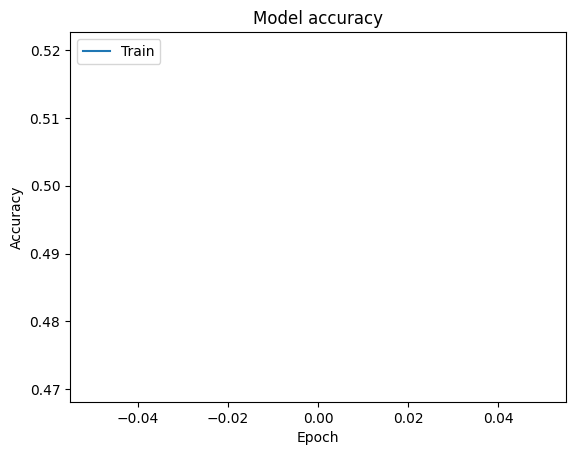

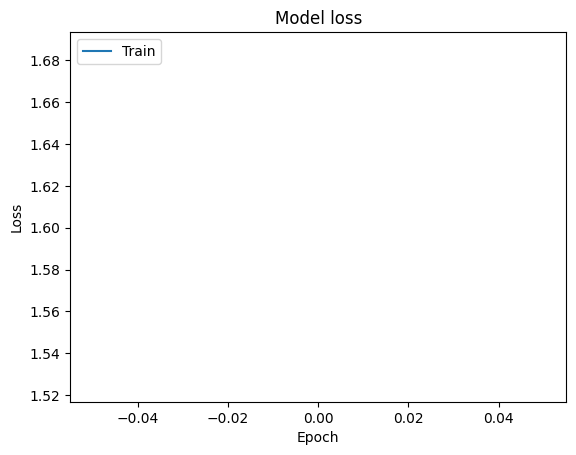

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['token_accuracy'])
#plt.plot(history.history['val_token_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.show()

## 10. Exact-sequence evaluation

We can now evaluate the model by computing exact string match accuracy on the test set.

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()